# Prova Final de Análise Estatística de Dados e Informações

**Aluno:** Adam Victor Nazareht Brandizzi

## Questão 1

Vamos montar um modelo de regressão linear para prever os preços de imóveis da região de King County dos Estados Unidos, usando a base de dados _[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)_. Este exercício têm 5 fases.

### Análise descritiva de dados

Carreguemos o modelo:

In [1]:
from brandedpipes import __
import kagglehub
from kagglehub import KaggleDatasetAdapter
from glob import glob
from pathlib import Path
import pandas as pd

pd.set_option('display.float_format', '{:.3f}'.format)

datadir = Path(kagglehub.dataset_download("harlfoxem/housesalesprediction"))
print(datadir)
datafiles = __| datadir.glob('*') | list |__
print(datafiles)
datafile = datafiles[0]
# Load the latest version
q1_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "harlfoxem/housesalesprediction",
  datafile.name,
)

/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1
[PosixPath('/home/adam/.cache/kagglehub/datasets/harlfoxem/housesalesprediction/versions/1/kc_house_data.csv')]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503


Vejamos que colunas temos:

In [2]:
DF = pd.DataFrame

q1_columns_df = DF({
    'type': q1_df.dtypes
})

q1_columns_df

,type
id,int64
date,object
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64


Temos 19 colunas. Queremos um preditor para a coluna `price`:

In [3]:
y = q1_df['price']

Todas as demais colunas são de interesse, exceto por `id`, que é apenas um identificador arbitrário.

A coluna `date` (data da venda) é interessante, porque pode ajudar a modelar informação sobre o estado do mercado em um ponto do tempo. Contudo, vamos ignorá-la porque, numa aplicação do modelo em que a usássemos, teríamos de passar também uma data esperada da venda. Ideia interessante, mas me parece fora do escopo.

In [4]:
X = q1_df.drop(['id', 'price', 'date'], axis=1)

Todas as colunas restantes codificadas como inteiros ou ponto flutuantes. Algumas têm valor categórico evidente, como `waterfront` (que é basicamente um `bool`), `view`, `condition`, `grade` e `zipcode`.

In [5]:
def puv(df, column):
    """
    [P]rint [U]nique [V]alues
    """
    print(f'Valores únicos de {column}:', df[column].unique())
puv(q1_df, 'waterfront')
puv(q1_df, 'view')
puv(q1_df, 'condition')
puv(q1_df, 'grade')
puv(q1_df, 'zipcode')

Valores únicos de waterfront: [0 1]
Valores únicos de view: [0 3 4 2 1]
Valores únicos de condition: [3 5 4 1 2]
Valores únicos de grade: [ 7  6  8 11  9  5 10 12  4  3 13  1]
Valores únicos de zipcode: [98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


Como `waterfront`, representando um valor booleano, já está praticamente na forma _one-hot encoding_, e a maioria das demais possuem uma ordenação intrísceca, não vamos expandi-las. `zipcode`, porém, provavelment precisará de alguns ajustes que faremos em breve.

Note também que não há nenhuma columa com valor em falta. Isso vai nos salvar de casos de borda e é um sinal de qualidade

In [6]:
def gnanc(df):
    """[G]et [NaN] [C]olumns"""
    columns = df.columns
    return DF({
        'column': columns,
        'hasNaN': [df[c].isnull().any() for c in columns]
    })
gnanc(q1_df)

,column,hasNaN
0,id,False
1,date,False
2,price,False
3,bedrooms,False
4,bathrooms,False
5,sqft_living,False
6,sqft_lot,False
7,floors,False
8,waterfront,False
9,view,False


#### Examinando `price` (valor a prever)

Vejanos as estatísticas dos preços

In [7]:
y_df = DF(q1_df['price'])
y_df.describe()

,price
count,21613.000
mean,540088.142
std,367127.196
min,75000.000
25%,321950.000
50%,450000.000
75%,645000.000
max,7700000.000


Notamos que o preço tem uma variação muito grande. O desvio padrão é quase cinco vezes maior que o menor valor, e mais que a metade da média e mediana. Isto fica ainda mais evidente no boxplot:

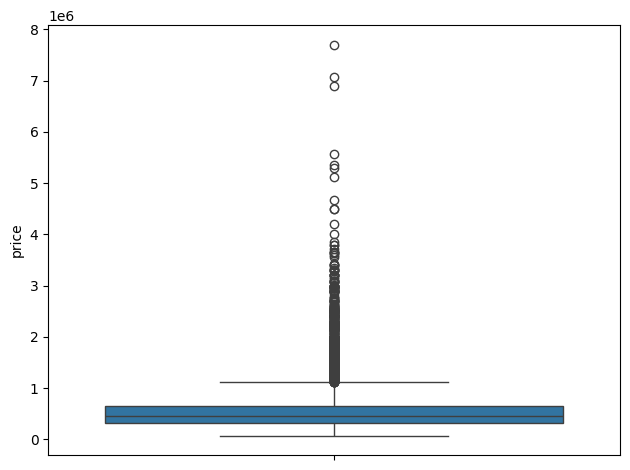

In [8]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot(df, column):
    sns.boxplot(data=df, y=column)
    plt.tight_layout()
    plt.show()
boxplot(y_df, 'price')

Isso pode tornar interessante examinar também o logaritmo do preço:

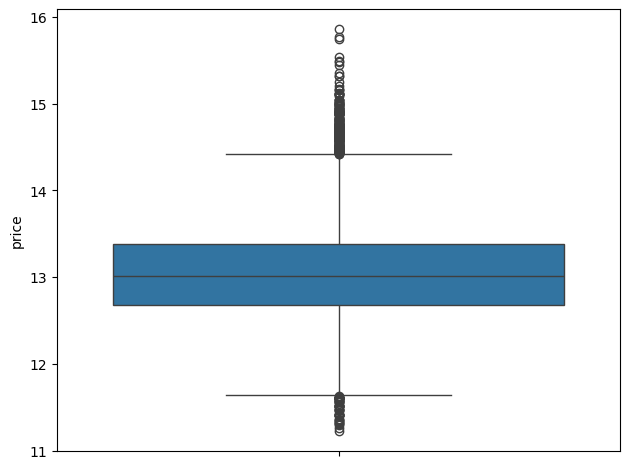

,price
count,21613.000
mean,13.048
std,0.527
min,11.225
25%,12.682
50%,13.017
75%,13.377
max,15.857


In [9]:
import numpy as np 

y_log_df = np.log1p(y_df)
boxplot(y_log_df, 'price')
y_log_df.describe()

A discrepância realmente foi amenizada pela logaritimização. Vejamos como isso afeta as correlações.

#### Correlação entre fatores e saída

Vamos ver a correlação das variáveis com o preço, e com o log do preço:

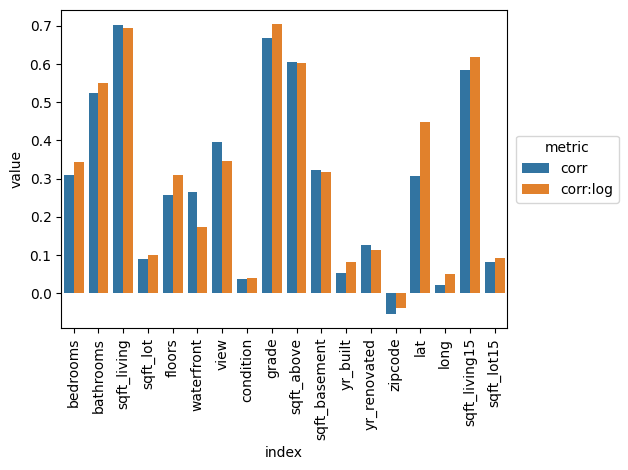

,corr,corr:log
zipcode,-0.053,-0.038
long,0.022,0.050
condition,0.036,0.040
yr_built,0.054,0.081
sqft_lot15,0.082,0.092
sqft_lot,0.090,0.100
yr_renovated,0.126,0.114
floors,0.257,0.311
waterfront,0.266,0.175
lat,0.307,0.449


In [10]:
X_y_corr = X.corrwith(y)
X_y_log_corr = X.corrwith(y_log_df['price'])
X_y_corr_df = DF(
  {
    'corr': X_y_corr,
    'corr:log':  X_y_log_corr
  }
)

X_y_corr_long = (
    X_y_corr_df
        .reset_index()
        .melt(
            id_vars='index',
            var_name='metric',
            value_name='value'
        )
)

sns.barplot(
    data=X_y_corr_long,
    x='index',
    y='value',
    hue='metric'
)
plt.legend(
    title='metric',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


X_y_corr_df.sort_values(by='corr')

A correlação do _log do preço_ dos imóveis  com cada um dos campos é ligeiramente melhor que a correlação com o preço original na maior parte das colunas, e quando não é, a diferença é minúscula. Tudo indica que utilizar o log do preço será mais vantajoso.

Vamos então  Com essas informações em mãos, vamos analisar os campos.

#### Campo `zipcode`

A menor correlação é o `zipcode`: -0.038. Faz sentido: é uma variavel categórica cujo suposto valor numérico nada descreve sobre o imóvel. O fato de ter uma correlação tão baixa é praticamente um bom exemplo de como o valor numérico é aleatório.

Ainda assim, ZIP codes registram partes das cidades que diferem drasticamente entre si. De fato, se ordernarmos os ZIP codes por valor médio, obtemos uma relação visualmente muito semelhante a linear em escala logarítmica:

In [11]:
zc_means = (
    q1_df.groupby("zipcode")["price"]
      .median()
      .sort_values()
)

zc_df = DF(
    zc_means
)
zc_df['position'] = range(len(zc_means))

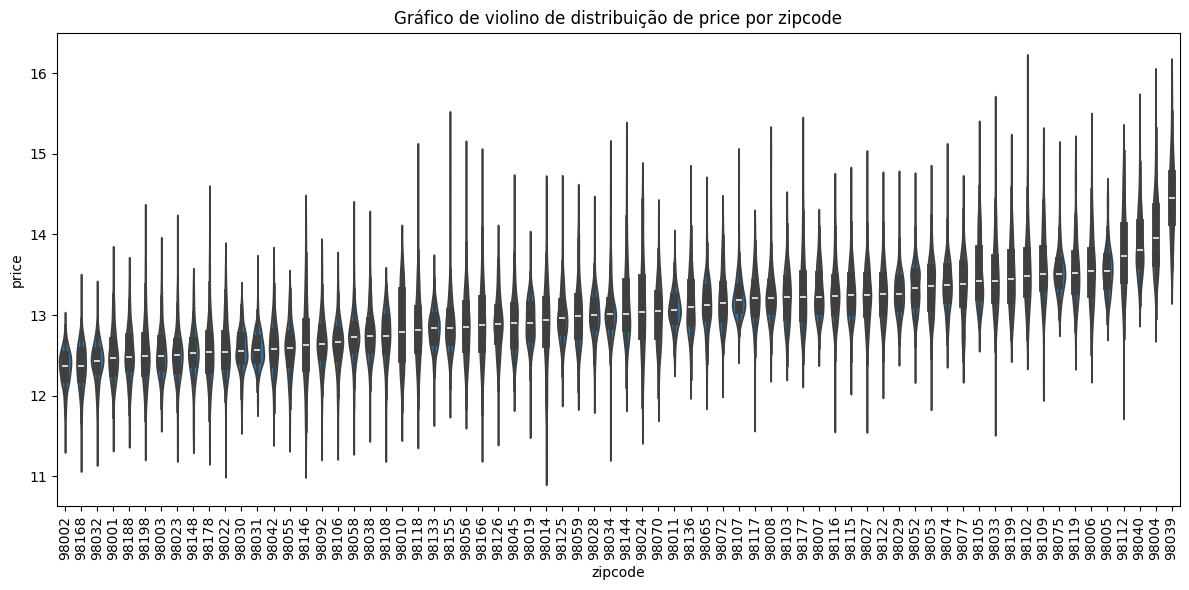

In [12]:
def violin(x, y):
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        x=x,
        y=y,
        order=zc_means.index,
        inner="box",
    )
    plt.title(f'Gráfico de violino de distribuição de {y.name} por {x.name}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

violin(X['zipcode'], y_log_df['price'])

Assim, se adicionarmos coluna com o índice do ZIP code ordenado por média, e outra com o logaritmo do preço, temos valores potencialmente correlacioados:

In [13]:
X['zipcode:position'] = [
    zc_df.loc[zc]['position'].astype(int) 
        for zc in X['zipcode']
]

A correlação com o logo do preço é muito maior agora, uma das mais relevantes, o que o torna um valor muito relevante para a previsão:

In [14]:
def print_corr(X, x_column, y, y_column):
    X_y_corr = X[x_column].corr(y_log_df[y_column])
    print(
        f'Correlação entre {x_column} e {y_column}: {X_y_corr:0.3f}',
    )

print_corr(X, 'zipcode:position', y_log_df, 'price')

Correlação entre zipcode:position e price: 0.714


Naturalmente, o ZIP code, como definido originalmente, não é mais de interesse:

In [15]:
X.drop('zipcode', axis=1, inplace=True)

#### Campos `condition` e `grade`

Condition tem a correlação mais baixa após o ZIP code não ordenado. Vejamos seu histograma para ver se há algo significativo a considerar:

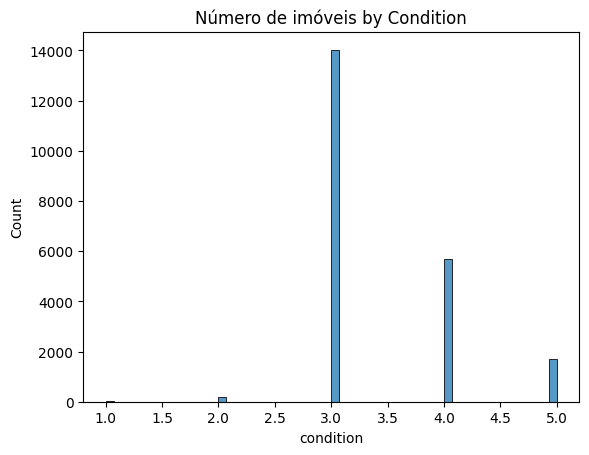

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,zipcode:position
condition,,,,,,,,,,,,,,,,,
1,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
2,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172
3,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031
4,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679
5,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(
    data=X,
    x='condition',
    kde=False,
    stat="count",
)

plt.title("Número de imóveis by Condition")
plt.show()

X.groupby('condition').count()

Notamos muito poucos valores nas condições 1 e 2, e um número desproporcional de valores na condição três (mais que doas as outras somadas!) Isso ajuda a explicar a baixa correlação. Poderíamos trabalhar com essa métrica usando SMOTE, por exemplo, mas como temos outras, vamos descartá-la.

In [17]:
X.drop('condition', axis=1, inplace=True)

Por outro lado, `grade` (que representa a qualidade fundacional do imóvel, ao invés do estado do acabamento) tem a mais alta correlação, depois do zipcode aptado e da área construída. Naturalmente, vamos mantê-lo.

##### `lat` e `long`

`long` (longitude) é o seguindo valor menos influente. Isso surpreeende, não só porque não segue a proverbial variação entre leste e oeste [[archplan.buffalo.edu](https://archplan.buffalo.edu/research/research-initiatives/seeitthrough/aschoolanditscity/eastwestdivide.html)] como também porque o condado varia bastante, com muito mais áreas urbanas a oeste:

<div style="max-width:400px">

![Mapa do condado de King](condado-de-king.png)

</div>

De qualquer forma, com uma correlação tão baixa, vamos descartar a longitude.

In [18]:
X.drop(['long'], axis=1, inplace=True)

Por outro lado, a latitude tem uma correlação até bem alta. Isso é surpreendente já que o condado tem meros 100 km de norte a sul [[your.kingcounty.gov](https://your.kingcounty.gov/dnrp/library/2008/kcr1973/kcr1973.pdf?utm_source=chatgpt.com)], o que por si só não deve causar grande variação em clima, e o mapa mostra certa uniformidade as várias faixas norte-sul.Talvez a latitude estreja representada (até com mais granuaridade e interpretabilidade) nos ZIP codes, mas vamos mantê-la dada sua alta correlação com o preço.

#### Campos `sqft_lot` e `sqft_lot15`

Também surpreende a baixa correlação de `sqft_lot` (0,09) e `sqt_lot15` (0,1). Suas estatisticas mostram uma variação bem grande, com desvio-padrão maior até que o valor médio e mediano. 

In [19]:
X[['sqft_lot', 'sqft_lot15']].describe()

,sqft_lot,sqft_lot15
count,21613.000,21613.000
mean,15106.968,12768.456
std,41420.512,27304.180
min,520.000,651.000
25%,5040.000,5100.000
50%,7618.000,7620.000
75%,10688.000,10083.000
max,1651359.000,871200.000


No boxplot, notamos outliers bem extremos (sinais de terrenos industriais e rurais):

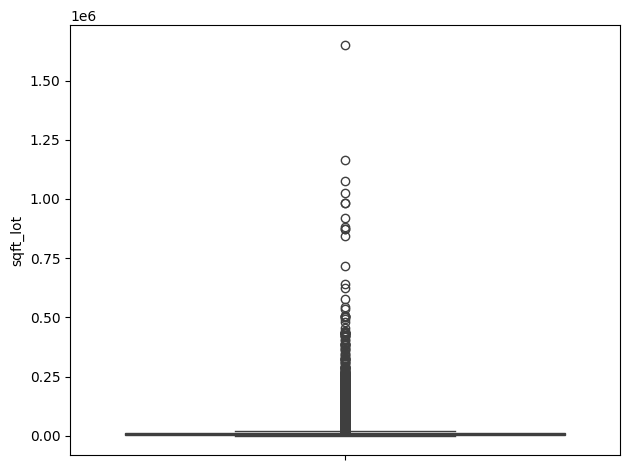

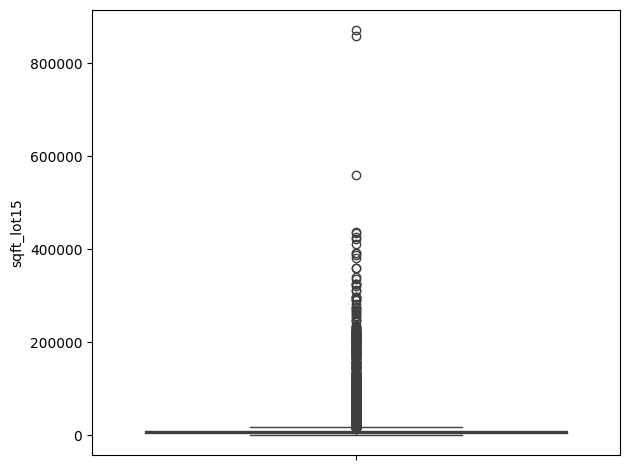

In [20]:
boxplot(X, 'sqft_lot')
boxplot(X, 'sqft_lot15')

Com esses extremos, convém observar os logaritmos dos valores:

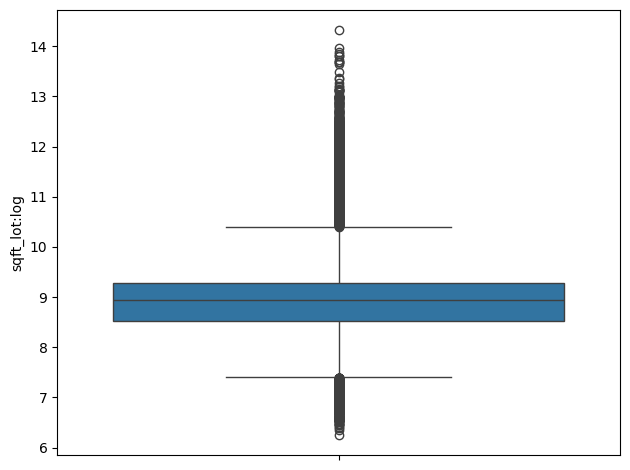

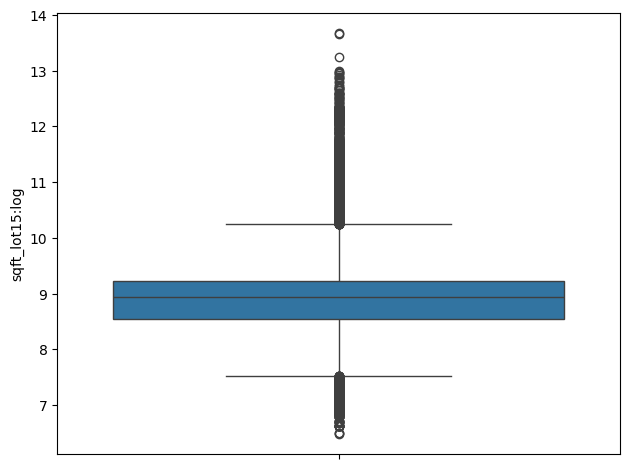

,sqft_lot:log,sqft_lot15:log
count,21613.000,21613.000
mean,8.990,8.961
std,0.902,0.813
min,6.254,6.479
25%,8.525,8.537
50%,8.938,8.939
75%,9.277,9.219
max,14.317,13.678


In [21]:
X['sqft_lot:log'] = np.log(X['sqft_lot'])
X['sqft_lot15:log'] = np.log(X['sqft_lot15'])
boxplot(X, 'sqft_lot:log')
boxplot(X, 'sqft_lot15:log')
X[['sqft_lot:log', 'sqft_lot15:log']].describe()

Os valores ficaram bem mais razoáveis. Como se correlacionam com o preço?

In [22]:
print_corr(X, 'sqft_lot:log', y_log_df, 'price')
print_corr(X, 'sqft_lot15:log', y_log_df, 'price')

Correlação entre sqft_lot:log e price: 0.138
Correlação entre sqft_lot15:log e price: 0.123


A correlação melhorou bastante, então vamos descartar os valores originais. Como `sqft_lot` e `sqft_lot15` são também naturalmente correlacionados, vamos descartar `sqft_lot15:log`.

In [23]:
X.drop(['sqft_lot', 'sqft_lot15', 'sqft_lot15:log'], axis=1, inplace=True)

Também podemos explorar a linearidade entre os valores:

<Figure size 800x500 with 0 Axes>

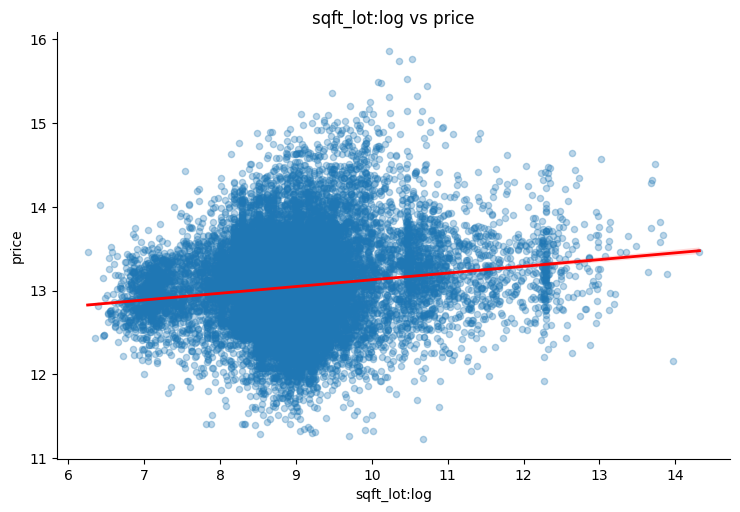

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(x, y):
    df = DF({
        x.name: x.values,
        y.name: y.values
    })
    plt.figure(figsize=(8,5))
    #sns.regplot(data=df, x=x.name, y=y.name, alpha=0.4);
    sns.lmplot(data=df, x=x.name, y=y.name,
           height=5, aspect=1.5,
               scatter_kws={'s':20, 'alpha':0.3},
              line_kws={'color': 'red', 'linewidth': 2})
    plt.title(f'{x.name} vs {y.name}')
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    
    plt.show()

scatter(X['sqft_lot:log'], y_log_df['price'])

A maior preocupação aqui é a variação no resíduo, mas nesse gráfico ao menos a relação entre log da área e log do preço parece razoavelmente linear.

#### Campos `sqft_basement` e `sqft_above`

Como analisamos as colunas com valores de área de terreno, vamos analisar as colunas com valores de área construída. Comecemos com `sqft_basement`.

O campo `sqft_basement` tem correlação 0.317, a menor de todas os dados de áreas construídas. Vejamos as estatísticas:

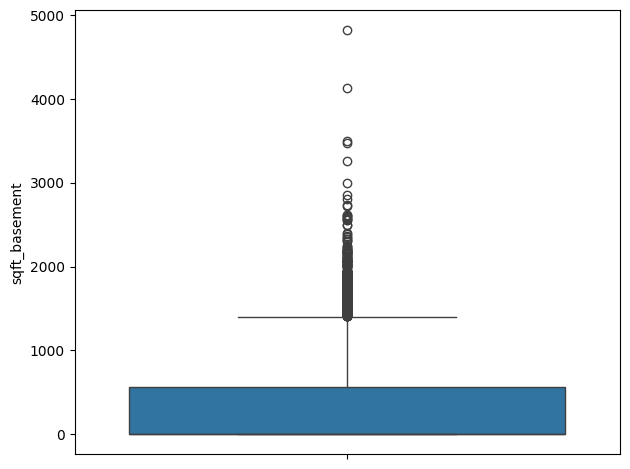

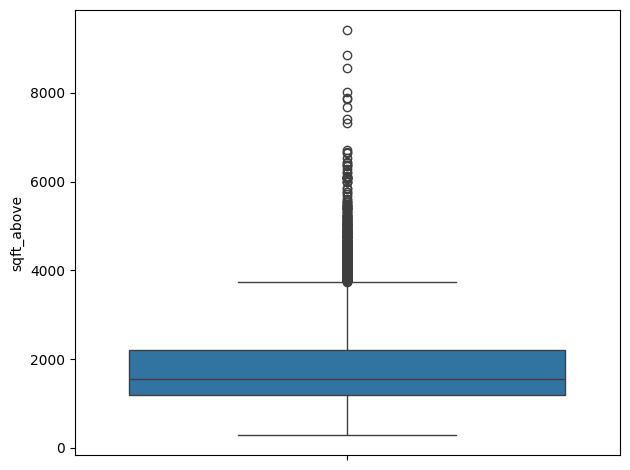

,sqft_basement,sqft_above
count,21613.000,21613.000
mean,291.509,1788.391
std,442.575,828.091
min,0.000,290.000
25%,0.000,1190.000
50%,0.000,1560.000
75%,560.000,2210.000
max,4820.000,9410.000


In [25]:
boxplot(X, 'sqft_basement')
boxplot(X, 'sqft_above')
X[['sqft_basement', 'sqft_above']].describe()

Notamos que a área de porão tem uma variação muito grande, com desvio-padrão muito maior que a média. Faz sentido: a maioria imóveis simplesmente não têm porão.

Talvez a mera presença do porão seja um bom preditor? Vejamos:

In [26]:
X['basement'] = X['sqft_basement'] > 0.1
print_corr(X, 'basement', y_log_df, 'price')

Correlação entre basement e price: 0.212


Ao contrário: a presença de porão se correlaciona menos ainda com o preço.

`sqft_above`, por outro lado, tem uma correlação maior com o preço: 0,606. Não só isso, mas o valor `sqft_living` é igual a soma de `sqft_above` e `sqft_basement`. Um dos valores deve ser retirado para evitar colinearidades. Como `sqft_basement` tem a menor correlação, o removemos.

In [27]:
X.drop(['sqft_basement', 'basement'], axis=1, inplace=True)

Como fica a lienaridade entre esses valores e o preço? VEjamos:

<Figure size 800x500 with 0 Axes>

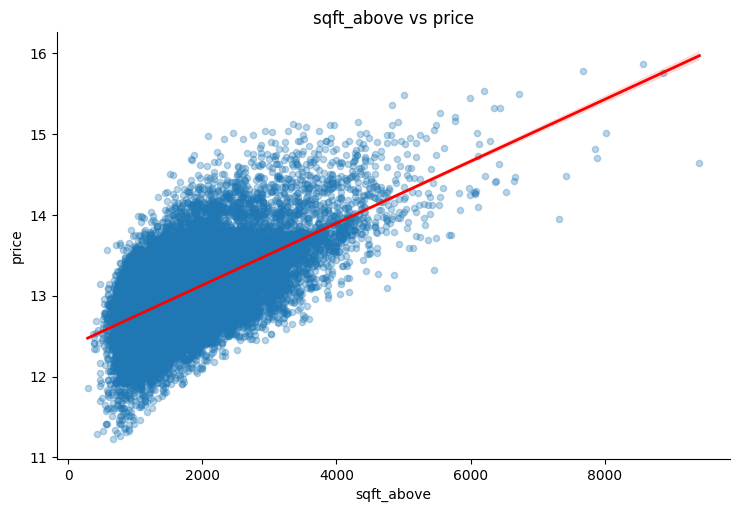

In [28]:
scatter(X['sqft_above'], y_log_df['price'])

Nada mau! Mas os outliers causaram uma certa estranheza. Vamos calcular com o log da área:

Correlação entre sqft_above:log e price: 0.586


<Figure size 800x500 with 0 Axes>

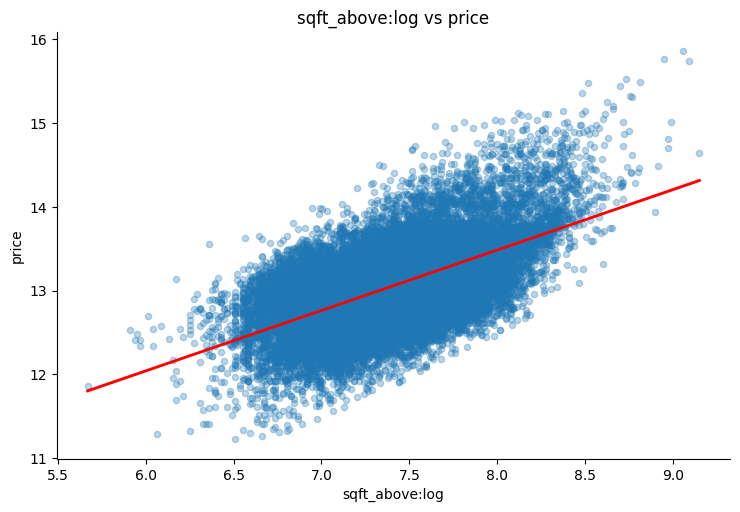

In [29]:
X['sqft_above:log'] = np.log(X['sqft_above']) 
print_corr(X, 'sqft_above:log', y_log_df, 'price')
scatter(X['sqft_above:log'], y_log_df['price'])

Conseguimos uma correlação ainda maior, e um gráfico claramente ainda mais linear. Vamos dispensar o valor bruto da área superior:

In [30]:
X.drop(['sqft_above'], axis=1, inplace=True)

#### Campos `sqft_living` e `sqft_living15`

Notamos claramente que `sqft_living` e `sqft_living15` têm grande correlação com o preço: `sqft_living15` tem correlação 0,585 e `sqft_living` tem correlação 0.702, a maior das correlações de campos não procesados. (INteressante como a área construída vale tão mais que a área do terreno).

Vejamos suas métricas:

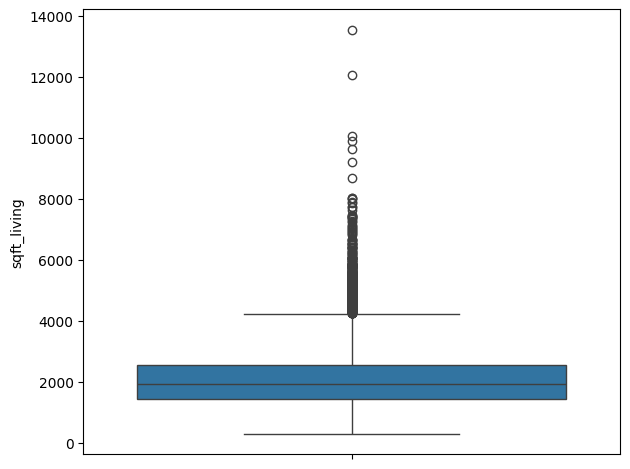

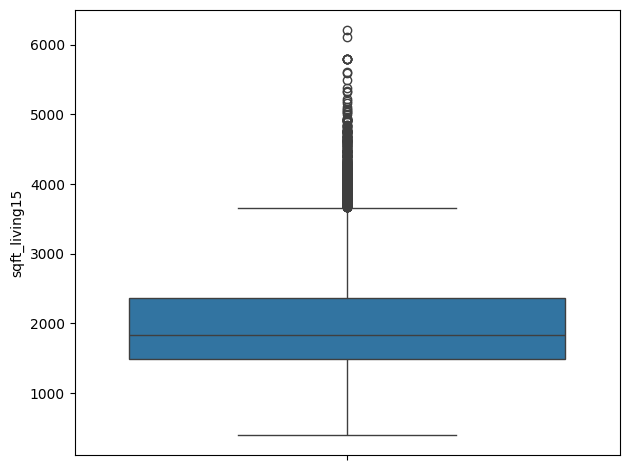

,sqft_living,sqft_living15
count,21613.000,21613.000
mean,2079.900,1986.552
std,918.441,685.391
min,290.000,399.000
25%,1427.000,1490.000
50%,1910.000,1840.000
75%,2550.000,2360.000
max,13540.000,6210.000


In [31]:
boxplot(X, 'sqft_living')
boxplot(X, 'sqft_living15')
X[['sqft_living', 'sqft_living15']].describe()

A área construída, é, claramente, não só altamente correlacionada, também são valores "bem comportados", como variância razoável. Ainda há outliers, porém, então exploremos o usuo de log:

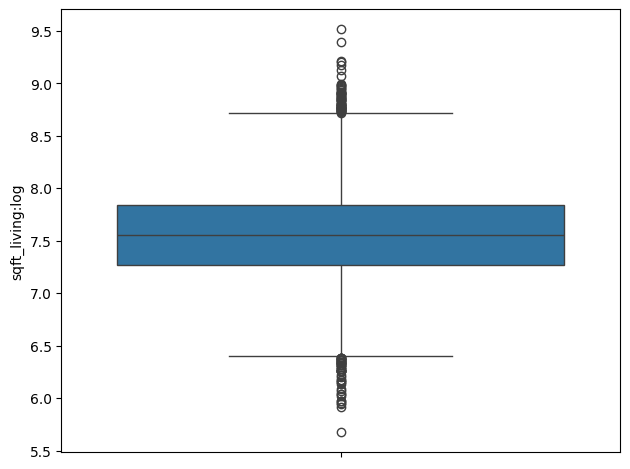

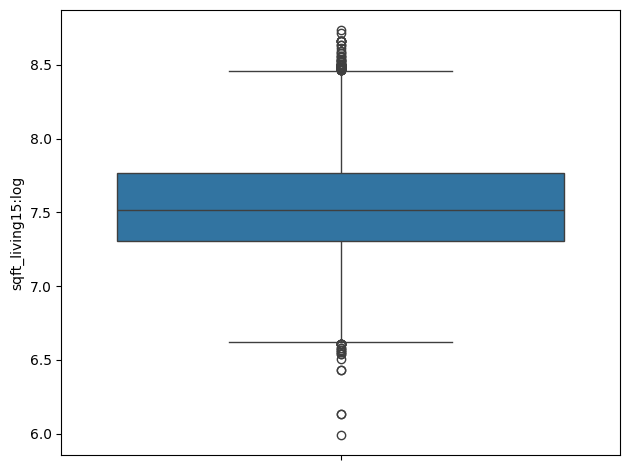

,sqft_living:log,sqft_living15:log
count,21613.000,21613.000
mean,7.551,7.540
std,0.425,0.327
min,5.673,5.991
25%,7.264,7.307
50%,7.555,7.518
75%,7.844,7.767
max,9.513,8.734


In [32]:
def clc(df, column):
    '''[C]reate [L]og [C]olumn'''
    df[f'{column}:log'] = np.log1p(X[column])
clc(X, 'sqft_living')
clc(X, 'sqft_living15')
boxplot(X, 'sqft_living:log')
boxplot(X, 'sqft_living15:log')
X[['sqft_living:log', 'sqft_living15:log']].describe()

O uso do logaritmo das áreas construídas amenizou as discrepâncias. Vejamos a linearidade:

<Figure size 800x500 with 0 Axes>

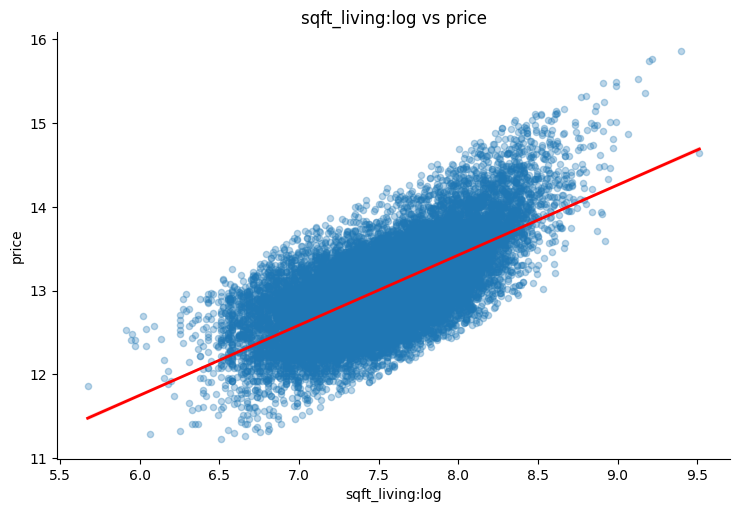

<Figure size 800x500 with 0 Axes>

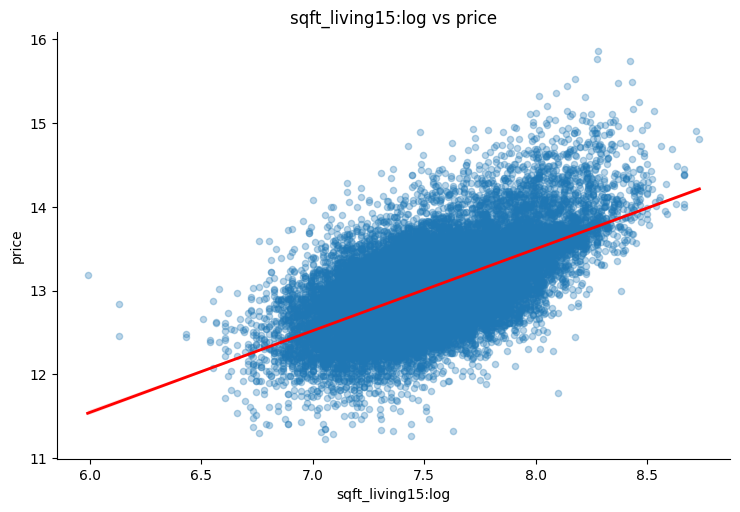

In [33]:
scatter(X['sqft_living:log'], y_log_df['price'])
scatter(X['sqft_living15:log'], y_log_df['price'])

A relação parece bem linear, inclusive com uma (aparente) distribuição normal dos resídulos. O valor do lote, não surpreendentemente, se correlacionou mais que o valor dos lotes vizinhos, então vamos descartar tanto os valores "brutos" quanto o logaritmo da média dos vizinhos:

In [34]:
X.drop(['sqft_living', 'sqft_living15', 'sqft_living15:log'], axis=1, inplace=True)

#### Campos `bathrooms` e `bedrooms`

O número de quartos e banheiros têm correlação significativa com o preço: `bedrooms` tem correlação de 0,344 enquanto `bathrooms` tem correlação de 0,551. Suas métricas são razoáveis, com médias próximas e desvio-padrão razoável, embora claramente haja vários outliers.

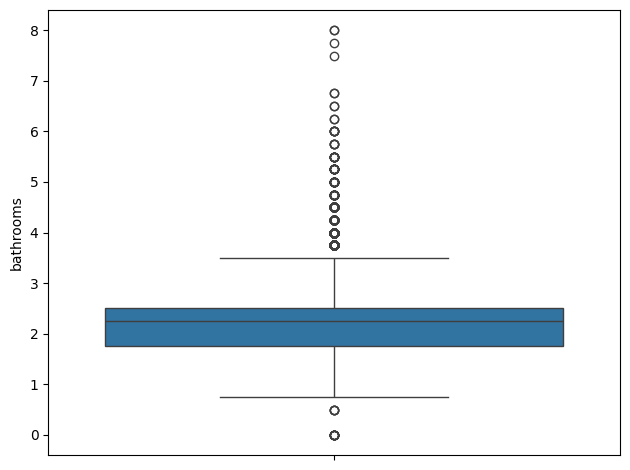

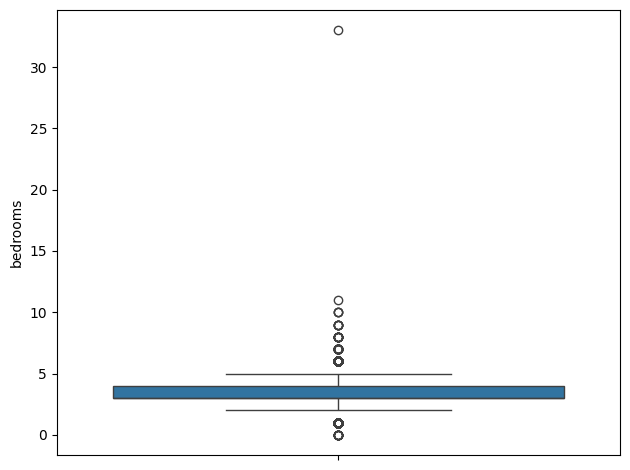

,bathrooms,bedrooms
count,21613.000,21613.000
mean,2.115,3.371
std,0.770,0.930
min,0.000,0.000
25%,1.750,3.000
50%,2.250,3.000
75%,2.500,4.000
max,8.000,33.000


In [35]:
boxplot(X, 'bathrooms')
boxplot(X, 'bedrooms')
X[['bathrooms', 'bedrooms']].describe()

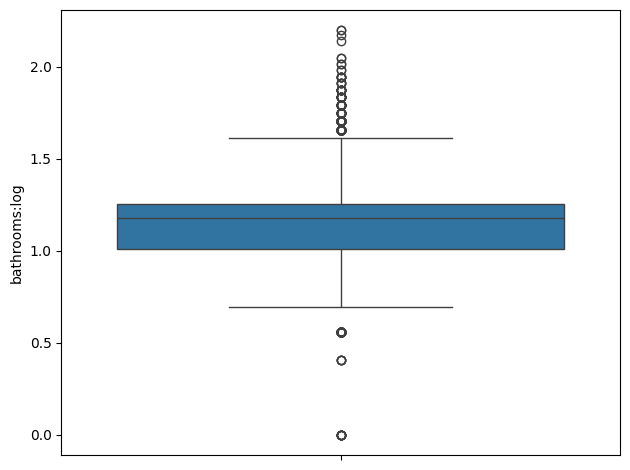

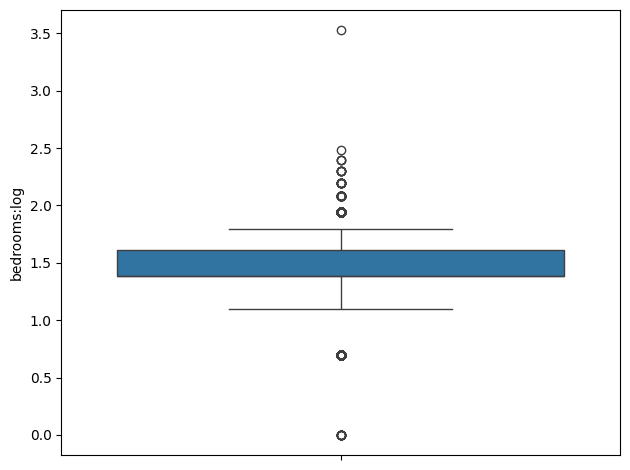

In [36]:
clc(X, 'bathrooms')
clc(X, 'bedrooms')
boxplot(X, 'bathrooms:log')
boxplot(X, 'bedrooms:log')

Como fica a correlação?

In [37]:
print_corr(X, 'bathrooms:log', y_log_df, 'price')
print_corr(X, 'bedrooms:log', y_log_df, 'price')

Correlação entre bathrooms:log e price: 0.532
Correlação entre bedrooms:log e price: 0.346


E a linearidade?

<Figure size 800x500 with 0 Axes>

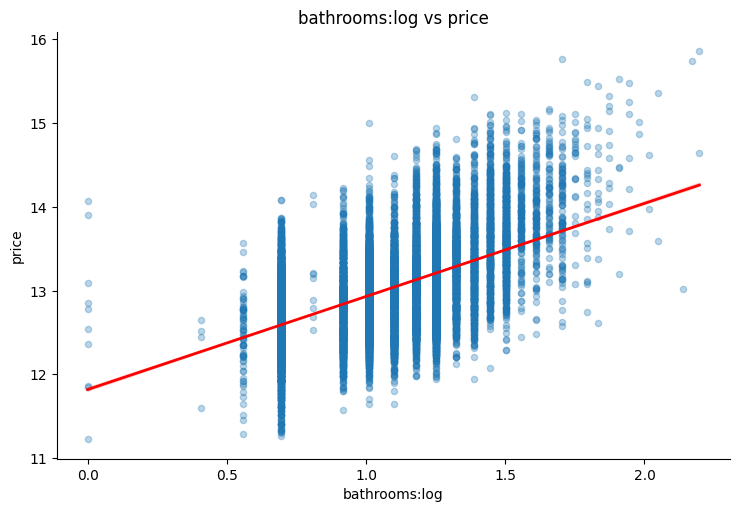

<Figure size 800x500 with 0 Axes>

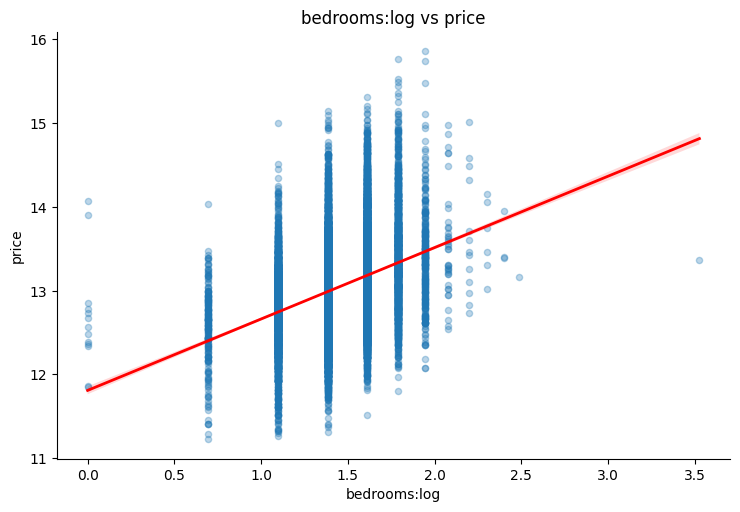

In [38]:
scatter(X['bathrooms:log'], y_log_df['price'])
scatter(X['bedrooms:log'], y_log_df['price'])

O número de quartos parece menos bem comportado, mas ainda segue uma certa linearidade.

In [39]:
X.drop(['bathrooms', 'bedrooms'], axis=1, inplace=True)

#### Campos `yr_built` e `yr_renovated`

O ano de construção de um imóvel é muito fracamente correlacionado: 0,081. 

O ano de renovação, porém, já tem uma correlação significativa, de 0,114. Vejamos suas estatísticas:

In [40]:
X[['yr_built', 'yr_renovated']].describe()

,yr_built,yr_renovated
count,21613.000,21613.000
mean,1971.005,84.402
std,29.373,401.679
min,1900.000,0.000
25%,1951.000,0.000
50%,1975.000,0.000
75%,1997.000,0.000
max,2015.000,2015.000


Aqui já notamos um problema: nem todas as casas foram renovadas! Vejamos quais anos incluem renovação:

In [41]:
X[X['yr_renovated'] > 0.1]['yr_renovated'].count()

np.int64(914)

In [42]:
X[X['yr_renovated'] > 0.1]['yr_renovated'].unique()

array([1991, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2005, 2008, 2003,
       1984, 1954, 2014, 2011, 1974, 1983, 1945, 1990, 1988, 1957, 1977,
       1981, 1995, 2000, 1998, 1970, 1989, 2004, 1986, 2009, 2007, 1987,
       1973, 2006, 1985, 2001, 1980, 1971, 1979, 1997, 1950, 1969, 1948,
       2015, 1968, 2012, 1963, 1951, 1993, 1962, 1996, 1972, 1953, 1955,
       1982, 1956, 1940, 1976, 1946, 1975, 1958, 1964, 1959, 1960, 1967,
       1965, 1934, 1944])

Excluindo as casas não renovadas, há uma correlação significativa com o preço?

In [43]:
renovated = X['yr_renovated'] > 0.1
print_corr(X[renovated], 'yr_renovated', y_log_df[renovated], 'price')

Correlação entre yr_renovated e price: 0.196


Há uma correlação significativa, então não convém substituir por uma flag. Mas podemos remover o ano de construção.

In [44]:
X.drop('yr_built', axis=1, inplace=True)

#### Campo `view` e `waterfront`

Os campos que representama vista têm correlações significativas. `view`tem 0,347 e `waterfront` tem 0,175. Vamos mantê-los.

#### Correlações entre fatores

Estes são os fatores que temos no momento.

In [45]:
X.columns

Index(['floors', 'waterfront', 'view', 'grade', 'yr_renovated', 'lat',
       'zipcode:position', 'sqft_lot:log', 'sqft_above:log', 'sqft_living:log',
       'bathrooms:log', 'bedrooms:log'],
      dtype='object')

Como eles se correlacionam entre si? Vejamos:

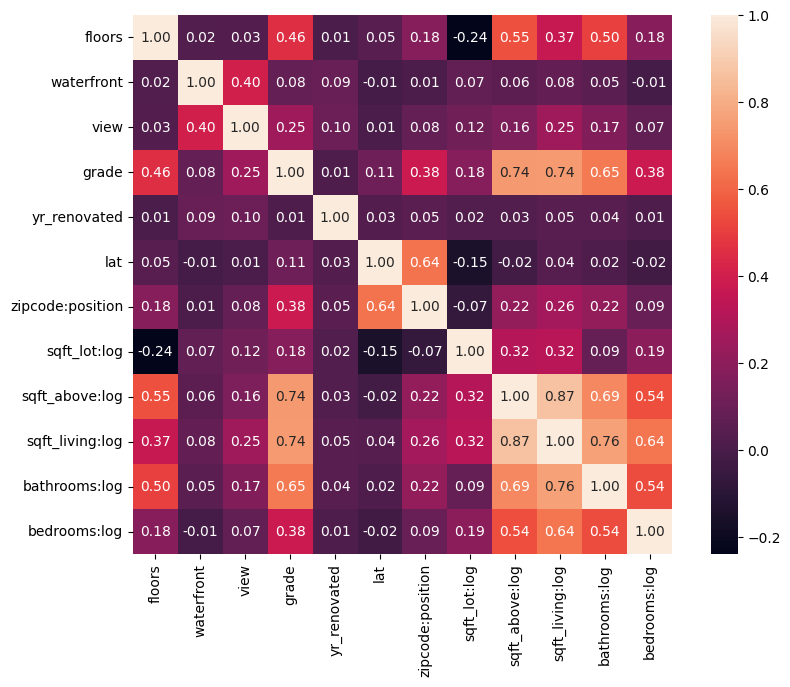

In [46]:
X_corr = X.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(X_corr, annot=True, fmt=".2f", square=True)
plt.show()

Temos muitos valores com alta correlação. Podemos reduzir bastante o número de parâmetros. Vamos ver as maiores:

In [47]:
columns = X.columns
X_corr_df = DF({
    'column1': [],
    'column2': [],
    'corr:abs': []
})
for i, c1 in enumerate(columns):
    for c2 in columns[i+1:]:
        X_corr_df.loc[len(X_corr_df)] = [c1, c2, abs(X_corr[c1][c2])]

X_corr_df.sort_values(by='corr:abs', ascending=False, inplace=True)
X_corr_df[X_corr_df['corr:abs'] > 0.7]

,column1,column2,corr:abs
60,sqft_above:log,sqft_living:log,0.865
63,sqft_living:log,bathrooms:log,0.764
35,grade,sqft_living:log,0.744
34,grade,sqft_above:log,0.743


Uma correlação tão alta entre área construída e área superior é esperada. Talvez valha a pena remover a área superior, dado que a mantemos para obter alguma informação sobre o porão, que, já sabemos, tem pouca influência:

In [48]:
X.drop('sqft_above:log', axis=1, inplace=True)

A relação entre área construída e banheiros também é esperada. Parece fazer sentido remover os banheiros também:

In [49]:
X.drop('bathrooms:log', axis=1, inplace=True)

Por outro lado, a relação entre `grade` e área é natural, mas são informações intríscecamente difernetes. Não vamos remover nenhuma por ora.

#### VIF

Como última validação antes da modelagem, vamos aplicar VIF para evitar colinearidades entre fatores:

In [50]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)

vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})

vif_df

,feature,VIF
0,const,209164.453
1,floors,1.534
2,waterfront,1.203
3,view,1.303
4,grade,2.790
5,yr_renovated,1.021
6,lat,1.763
7,zipcode:position,2.015
8,sqft_lot:log,1.395
9,sqft_living:log,3.831


Agora, todos os fatores são pouco correlacionados. Podemos treinar o modelo.

### Modelo de Regressão Linear

Com esses parâmetros, podemos treinar o nosso modelo.

In [51]:
from sklearn.model_selection import train_test_split

def train_linear_regression_model(X, y):
    (
        X_train,
        X_test,
        y_train,
        y_test
    ) = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit model
    model = sm.OLS(y_train, X_train).fit()
    return model, X_test, y_test

In [52]:
model, X_test, y_test = train_linear_regression_model(X, y_log_df['price'])

#### Performance do modelo
Vejamos sua performance:

In [53]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_linear_regression_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Metrics
    r2  = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)

    print(f"Metrics for {name}")
    print(f"  R²: {r2:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")

In [54]:
evaluate_linear_regression_model('first try', model, X_test, y_test)

Metrics for first try
  R²: 0.830
  RMSE: 0.048
  MAE: 0.166


Esses valores são excelentes! Especialmente quando consideramos os valores máximos:

In [55]:
y_test.max()

np.float64(15.532905791436665)

Os parâmetros do modelo:

In [56]:
DF(model.params)

,0
const,-14.371
floors,-0.012
waterfront,0.401
view,0.093
grade,0.100
yr_renovated,0.000
lat,0.481
zipcode:position,0.012
sqft_lot:log,0.004
sqft_living:log,0.440


### Ajuste dos modelo

#### One-hot enconding  para ZIP code

Ainda assim, podemos tentar melhorar o modelo. Por exemplo, o truque de ordenar os ZIP codes "funcionou" e nos salvou um bom número de parâmetros, mas e se utilizássemos one-hot encoding?

In [57]:
X_1he_zip = X.copy()
X_1he_zip.drop('zipcode:position', axis=1, inplace=True)
X_1he_zip['zipcode'] = q1_df['zipcode']
X_1he_zip = pd.get_dummies(X_1he_zip, columns=['zipcode'], drop_first=True, dtype=int)

In [58]:
model_1he_zip, X_test, y_test = train_linear_regression_model(X_1he_zip, y_log_df['price'])
evaluate_linear_regression_model('One-hot encoded ZIP code', model_1he_zip, X_test, y_test)

Metrics for One-hot encoded ZIP code
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


A melhora foi considerável, inegavelmente, mesmo que ao custo de muito mais colunas:

In [59]:
__| X.columns | len | print  |__
__| X_1he_zip.columns | len | print  |__

11
79


#### Adicionando longitude

Antes, removemos `long` porque havia pouca correlação, e queríamos reduzir o número de parâmetros. Se o adicionarmos de volta, haverá melhora? Vejamos.

In [60]:
X_long = X_1he_zip.copy()
X_long['long'] = q1_df['long']

In [61]:
model_long, X_test, y_test = train_linear_regression_model(X_long, y_log_df['price'])
evaluate_linear_regression_model('model with longitude', model_long, X_test, y_test)

Metrics for model with longitude
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Não houve melhora significativa. Não surpeende, mas levanta outra questão: se removermos tanto latitude quanto longitude do modelo com ZIP code codificado, qual seria o resultado?

#### Removendo coordenadas

Observemos primeiramente os parâmetros:

In [62]:
DF(model_long.params[[not s.startswith('zipcode_') for s in model_long.params.index]])

,0
const,-73.718
floors,0.008
waterfront,0.472
view,0.068
grade,0.108
yr_renovated,0.000
lat,0.524
sqft_lot:log,0.073
sqft_living:log,0.462
bedrooms:log,-0.042


Latitude e longitude ainda parecem bem relevantes! Treinemos um modelo para ver como funciona sem as coordenadas:

In [63]:
X_no_coords = X_1he_zip.copy()
X_no_coords.drop('lat', axis=1, inplace=True)

In [64]:
model_no_coords, X_test, y_test = train_linear_regression_model(X_no_coords, y_log_df['price'])
evaluate_linear_regression_model('model with no coordinates', model_no_coords, X_test, y_test)

Metrics for model with no coordinates
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Muito surpreendentemente, remover latitude e longitude simplesmente não teve efeito perceptível nas métricas! Se, por um lado, podemos esperar algo assim dado que ZIP codes encodam parte dessa informação, inclusive de maneira muito mais granular e sem as mudanças bruscas/não-lineares que se espera de coordenadas, é curioso ver que, parâmetros que atnes estavam tão relevantes, agora não são.

#### Removendo parâmetros com coeficientes minúsculos

Além disso, nota-se que o número de andares e o ano da renovação ambos têm coeficientes muito baixos. Faria diferença removê-los?

In [65]:
X_no_floor_yr = X_no_coords.copy()
X_no_floor_yr.drop(['floors', 'yr_renovated'], axis=1, inplace=True)

In [66]:
model_no_floor_yr, X_test, y_test = train_linear_regression_model(X_no_floor_yr, y_log_df['price'])
evaluate_linear_regression_model('model with no floor/renovation year', model_no_floor_yr, X_test, y_test)

Metrics for model with no floor/renovation year
  R²: 0.877
  RMSE: 0.035
  MAE: 0.138


Houve um aumento minúsculo dos erros, mas isso mostra como mesmo esses fatores tão pequenos podem ser relevantes. Vamos mantê-los.

#### Adicionando banheiros

Anteriormente, removemos os banheiros. E se o adissionássemos novamente? Eles são usualmente um sinal de qualidade da casa.

In [67]:
X_bathrooms = X_no_coords.copy()
X_bathrooms['bathrooms:log'] = np.log1p(q1_df['bathrooms'])

In [68]:
model_bathrooms, X_test, y_test = train_linear_regression_model(X_bathrooms, y_log_df['price'])
evaluate_linear_regression_model('model with bathrooms', model_bathrooms, X_test, y_test)

Metrics for model with bathrooms
  R²: 0.878
  RMSE: 0.035
  MAE: 0.137


Claramente, pouco afetou o resultado. Podemos experimentar mais, mas o modelo com ZIP code em one-hot encoding mas sem coordenadas é o melhor até o momento.

Vamos analisá-lo.

### Interpretação de resultados

Novamente, estes são os coeficientes dos parâmetros do modelo sem coordenadas (sem contar as flags dos ZIP codes):

In [69]:
DF(model_no_coords.params[[not s.startswith('zipcode_') for s in model_no_coords.params.index]])

,0
const,7.618
floors,0.006
waterfront,0.473
view,0.068
grade,0.108
yr_renovated,0.000
sqft_lot:log,0.071
sqft_living:log,0.464
bedrooms:log,-0.042


É interessante notar como o coeficiente da constante mudou drasticamente, de -14,4 no mdelo original, para 7,6! Faz sentido: como adicionamos ZIP code codificado com one-hot encoding, temos mais parâmetros para somar, logo nosso baseline deve ser maior. 

Antes de explorarmos os ZIP codes, notemos como o número de quartos tem um efeito negativo! É importante lembrar que este parâmetro é um log, então isso não significa que ter mais quartos vai necessariamente reduzir o preço, mas provavelmente o parâmetro se torna bem menos relevante, com um coeficiente menor que 1. Ainda assim, um efeito inesperado.

#### Efeito de ZIP code

Vejamos os ZIP codes:

In [79]:
zc_coefs = DF(model_no_coords.params[[s.startswith('zipcode_') for s in model_no_coords.params.index]]).sort_values(by=0)
zc_coefs[:10]

,0
zipcode_98023,-0.027
zipcode_98032,-0.022
zipcode_98003,0.007
zipcode_98002,0.024
zipcode_98092,0.033
zipcode_98022,0.055
zipcode_98030,0.055
zipcode_98198,0.065
zipcode_98168,0.074
zipcode_98042,0.080


In [81]:
zc_coefs[59:]

,0
zipcode_98107,0.887
zipcode_98199,0.888
zipcode_98040,0.928
zipcode_98105,1.006
zipcode_98119,1.009
zipcode_98102,1.022
zipcode_98109,1.046
zipcode_98112,1.110
zipcode_98004,1.164
zipcode_98039,1.378


Os coeficientes dos ZIP codes ainda são bem pequenos. Como é possível, então, que valores tão grandes quanto o preço de imóveis seja previsto a partir desses coeficientes? Para começar, estamos modelando o logaritmo do preço dos imóveis, não o preço dos imóveis. Considerando isos, os ZIP codes na verdade têm uma influência bem dominadora, especialmente considerando regiões mais valisas.

Depois dos ZIP codes, a maior influência é a área construída, `sqft_living:log`. Claramente, o tamanho do terreno não é tão relevante (ou melhor, o efeito varia muito dependendo da região, talvez fosse mais efetivo junto com os ZIP codes). Os outros fatores são relevantes, mas têm certa correlação com o tamanho da área construída de qualquer forma.

### Aplicações

Vejamos os valores em números "reais" (valores em dólares):

In [93]:
model_no_coords, X_test, y_test = train_linear_regression_model(X_no_coords, y_log_df['price'])

y_pred = model_no_coords.predict(X_test)
y_test = np.exp(y_test)-1
y_pred = np.exp(y_pred)-1

# Metrics
r2  = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Metrics for 'real' price prediction with no-coords model")
print(f"  R²: {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE: {mae:.3f}")
print(f"  mean(y) / sd(y): {y.mean()} / {y.std()}")

Metrics for 'real' price prediction with no-coords model
  R²: 0.864
  RMSE: 20496040251.883
  MAE: 78493.135
  mean(y) / sd(y): 540088.1417665294 / 367127.1964826998


Nosso modelo possui um erro absoluto médio de aproximadamente US$ 78 mil quando aplicado. Considerando que os valores têm média de US$ 540 mil e variãncia de US$ 367 mil, esse erro é bem razoável!

Uma utilidade possível seria definir sugestões de preços iniciais para ofertas. Outra seria encontrar imóveis que, segundo o modelo, estariam subvalorizados. Poderíamos fazer isso com nossa base de testes, por sinal:

In [99]:
pred_df = DF({
    'predicted': y_pred,
    'real': y_test,
    'diff': y_pred-y_test
})
pred_df[pred_df['diff'] > 0].head()

,predicted,real,diff
4106,1265597.268,1038000.000,227597.268
1227,267791.790,211000.000,56791.790
20164,420491.673,384500.000,35991.673
13342,445331.966,385000.000,60331.966
15468,264598.142,175000.000,89598.142


Se o modelo se provar correto, a arbitragem só nos cinco imóveis mais subvalorizados daria quase US$ 500 mil de lucro!

Naturalmente, essa não é uma fórmula a ser seguida cegamente, mas pode apontar possíveis oportunidades a serem availadas.

In [ ]:
# Sandbox